<hr/>
<div class="alert alert-success alertsuccess" style="margin-top: 20px">
[Tip]: To execute the Python code in the code cell below, click on the cell to select it and press <kbd>Shift</kbd> + <kbd>Enter</kbd>.
</div>
<hr/>

# Required Libraries

In [109]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from os.path import exists

sns.set_style("white")
sns.set_palette("coolwarm")


def load_polic_data():
    local = "11police_project.csv"
   
    if exists(local):
        print ("Read from local file")
        return pd.read_csv(local)
    else:
        print ("Read from hu-box")        
        return pd.read_csv("https://box.hu-berlin.de/f/cc297480d22c42a6ae3e/?dl=1")


def load_data():
    df = load_polic_data()
    df.loc[df.stop_duration == '2', "stop_duration"] = '0-15 Min'
    df.loc[df.stop_duration == '1', "stop_duration"] = '0-15 Min'
    df.drop_duplicates(inplace=True)
    
    df.search_type = df.search_type.str.split(",")
    
    columns=["driver_gender", "driver_race", "violation", "stop_outcome", "stop_duration"]
    for col in columns:
        df[col] = df[col].astype("category")
    
    # Dropping the state and county name columns
    df.drop(["county_name","driver_age_raw"], axis='columns', inplace=True)
    
    # Dropping  the NaN in both gender and driver columns
    df.dropna(subset=["driver_gender","driver_race","driver_age"], inplace=True)
    
    new_date = df["stop_date"].str.cat(df["stop_time"], sep=" ")
    df['stop_datetime'] = pd.to_datetime(new_date)
    df.set_index("stop_datetime", inplace=True)
    
    df = df.convert_dtypes()
    
    return df

<hr> 

# Exercise 3: Bias and Fairness in Traffic Stops

### This notebook is split into ten tasks. You must solve at least 6 out of 10 tasks correctly.
    
1. Assess the impact of race, gender, and age on the frequency of police traffic stops.
2. Evaluate how gender influences police behavior during traffic stops.
3. Examine whether gender affects the likelihood of being frisked during a search.
4. Compare frisk rates during searches between males and females.
5. Compare frisk rates during searches between Black and White drivers.
6. Determine which gender is more likely to be arrested during a traffic stop.
7. Investigate the impact of driver age on the likelihood of being stopped.
8. Analyze whether stop duration influences the probability of an arrest.
9. Study how stop duration has changed over time to identify evolving policing practices.
10. Use a large language model to suggest additional insightful analyses of the dataset.

### You must hand in this exercise via Moodle.

## Dataset

This dataset contains records of traffic stops conducted by police officers across the United States from 2005 to 2015. It details the circumstances and outcomes of these stops. The data was sourced from the Stanford Open Policing Project, which collects and standardizes traffic stop data from law enforcement agencies nationwide. One of the project's main goals is to analyze and improve interactions between police and the public. The dataset encompasses stops made across all U.S. states during the specified period. It has 85845 rows × 13 columns.

<img src="https://images.pexels.com/photos/7715199/pexels-photo-7715199.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500">

In [110]:
# DO NOT CHANGE THIS CODE
df = load_data()
df.head()

Read from hu-box


,stop_date,stop_time,driver_gender,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
stop_datetime,,,,,,,,,,,,,
2005-01-02 01:55:00,2005-01-02,01:55,M,20,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2005-01-18 08:15:00,2005-01-18,08:15,M,40,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2005-01-23 23:15:00,2005-01-23,23:15,M,33,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2005-02-20 17:15:00,2005-02-20,17:15,M,19,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
2005-03-14 10:00:00,2005-03-14,10:00,F,21,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [111]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85845 entries, 2005-01-02 01:55:00 to 2015-12-31 22:46:00
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   stop_date           85845 non-null  string  
 1   stop_time           85845 non-null  string  
 2   driver_gender       85845 non-null  category
 3   driver_age          85845 non-null  Int64   
 4   driver_race         85845 non-null  category
 5   violation_raw       85845 non-null  string  
 6   violation           85845 non-null  category
 7   search_conducted    85845 non-null  boolean 
 8   search_type         3184 non-null   object  
 9   stop_outcome        85845 non-null  category
 10  is_arrested         85845 non-null  boolean 
 11  stop_duration       85845 non-null  category
 12  drugs_related_stop  85845 non-null  boolean 
dtypes: Int64(1), boolean(3), category(5), object(1), string(3)
memory usage: 4.9+ MB


In [112]:
df.describe(include=["string", "category"])

,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,stop_outcome,stop_duration
count,85845,85845,85845,85845,85845,85845,85845,85845
unique,3767,1432,2,5,12,6,6,3
top,2012-02-28,10:00,M,White,Speeding,Speeding,Citation,0-15 Min
freq,64,297,62446,61758,48217,48217,76592,69162


In [113]:
df.describe()

,driver_age
count,85845.0
mean,34.013291
std,12.73767
min,15.0
25%,23.0
50%,31.0
75%,43.0
max,99.0


### Some simple formatting inspirations for displaying percentages

In [114]:
# Compute percentage of genders
series = df["driver_gender"].value_counts().transform(lambda l: l / l.sum())

# Using '.style.format'
pd.DataFrame(series).style.format({'count': '{:.2%}'}).background_gradient(cmap='Blues')

,count
driver_gender,
M,72.74%
F,27.26%


In [115]:
# Compute ratio of driver race and gender while traffic stops
gender_race_ratio = pd.crosstab(df.driver_gender, df.driver_race, normalize=True)

# Format nicely
gender_race_ratio.style.format({
    'Asian': '{:.2%}', 'Black': '{:.2%}', 'Hispanic': '{:.2%}', 'Other': '{:.2%}', 'White': '{:.2%}'
}).background_gradient(cmap='Blues')

driver_race,Asian,Black,Hispanic,Other,White
driver_gender,,,,,
F,0.60%,2.99%,2.17%,0.03%,21.47%
M,2.02%,11.17%,8.83%,0.25%,50.47%


### Using a Countplot

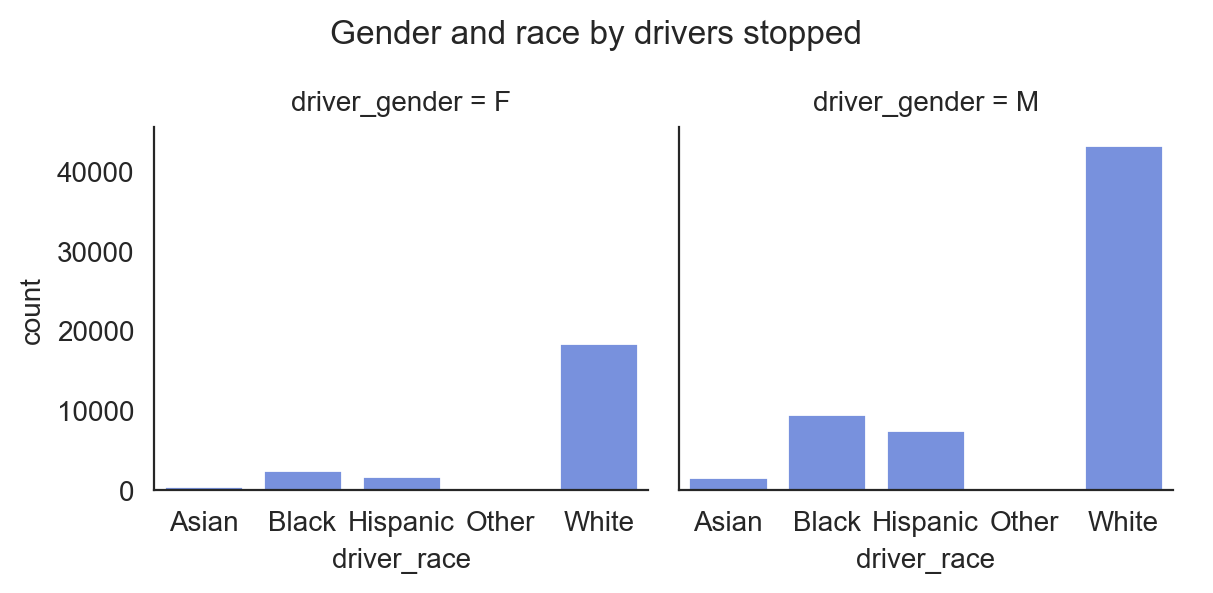

In [116]:
g = sns.catplot(
    data=df,
    x="driver_race", 
    col="driver_gender", 
    kind="count",
    height=3, aspect=1.,
)
g.fig.suptitle("Gender and race by drivers stopped")
g.fig.subplots_adjust(top=0.8)
plt.show()

# Exploratory Data Analysis


## Task 1 -  Assess the impact of race, gender, and age on the frequency of police traffic stops.

<div class="alert alert-block alert-success">
    
- Create three separate plots to visualize the distribution of traffic stops across the categories driver_gender, driver_age, and driver_race.
- Provide a brief description.


</div>

Read from hu-box


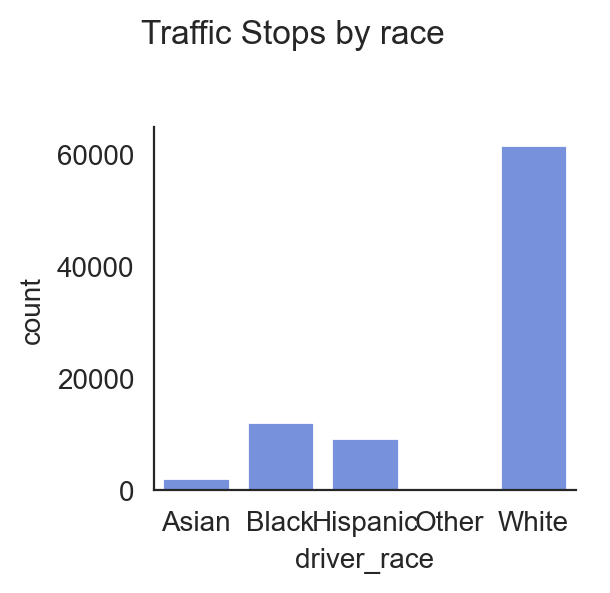

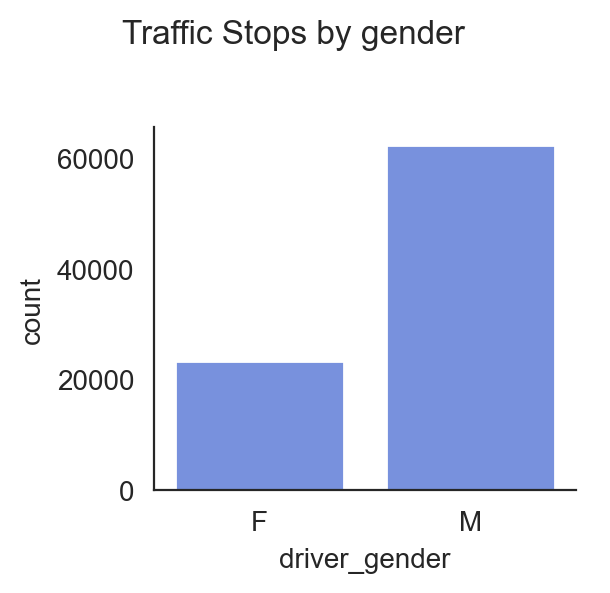

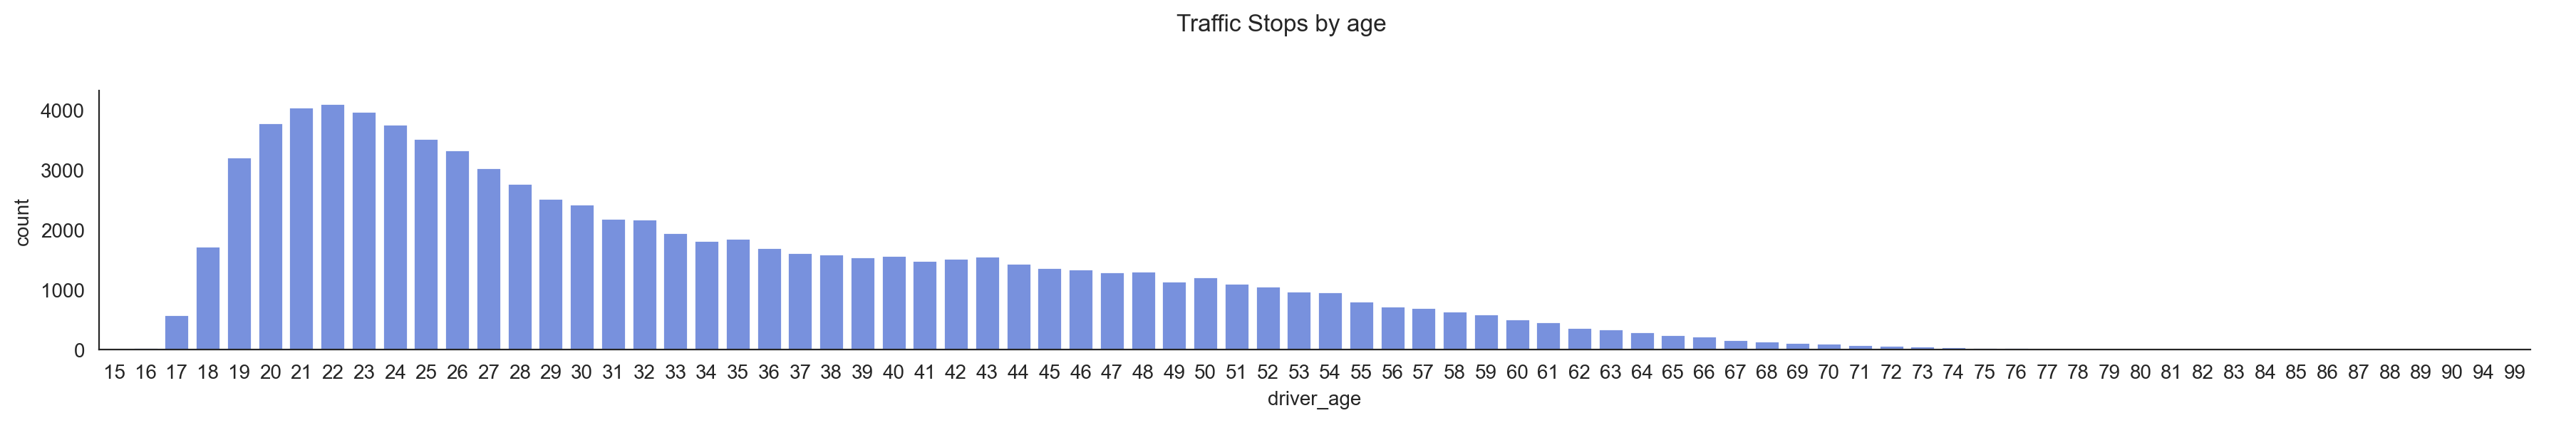

In [117]:
df = load_data()

g = sns.catplot(
    data=df,
    x="driver_race", 
     
    kind="count",
    height=3, aspect=1.,
)
g.fig.suptitle("Traffic Stops by race")
g.fig.subplots_adjust(top=0.8)
plt.show()

g = sns.catplot(
    data=df,
    x="driver_gender", 
    kind="count",
    height=3, aspect=1.,
)
g.fig.suptitle("Traffic Stops by gender")
g.fig.subplots_adjust(top=0.8)
plt.show()

g = sns.catplot(
    data=df,
    x="driver_age", 
    kind="count",
    height=3, aspect=6.,
)
g.fig.suptitle("Traffic Stops by age")
g.fig.subplots_adjust(top=0.8)
plt.show()

von 85845 Traffic Stops betrafem ca. 60000 Weiße Fahrer*innen.
von 85845 Traffic Stops betrafem ca. 60000 Männer.
21 bis 23 jährige wurde am meisten angehalten.

## Task 2 - Evaluate how gender influences police behavior during traffic stops.

Speeding is the most common reason for traffic stops across genders. 

<div class="alert alert-block alert-success">

- Analyze how the driver’s gender influences the distribution of `stop_outcome` specifically for stops involving the violation type `speeding`.
- The analysis can be tabular or visual.
- Provide a brief description.


</div>

Tabular-Results should be similar to this:

| stop_outcome     |           F |           M |
|:-----------------|------------:|------------:|
| Arrest Driver    | 0.00170065  | 0.0103076   |
| Arrest Passenger | 0.000269614 | 0.000850323 |
| Citation         | 0.304892    | 0.644316    |
| N/D              | 0.000269614 | 0.000725885 |
| No Action        | 0.000145177 | 0.000725885 |
| Warning          | 0.012506    | 0.0232905   |

In [118]:
df = load_data()


speeding_df = df[df["violation"] == "Speeding"]


gender_stop_outcome = pd.crosstab(
    speeding_df.stop_outcome,
    speeding_df.driver_gender,
    normalize="columns"
)

gender_stop_outcome


Read from hu-box


driver_gender,F,M
stop_outcome,,
Arrest Driver,0.005318,0.015153
Arrest Passenger,0.000843,0.001250
Citation,0.953434,0.947222
N/D,0.000843,0.001067
No Action,0.000454,0.001067
Warning,0.039108,0.034240


Frauen bekommen öfter Citation und Warnings, Arrests, N/D und No Actions sind bei Männern Häufiger.
(Angaben in Relation zu der Menge der Traffic Stops an Frauen und Männern)

## Task 3 - Examine whether gender affects the likelihood of being frisked during a search.

Protective frisk refers to a pat-down conducted by police during a vehicle search, typically to check for weapons.

<div class="alert alert-block alert-success">

- Analyze the *absolute frequency* of protective frisks (in `search_type`) by driver's gender.
- The analysis can be tabular or visual.
- Provide a brief description.

</div>

Tabular-Results should be similar to this:

| driver_gender   |   Protective Frisk |
|:----------------|-------------------:|
| F               |                 29 |
| M               |                241 |

In [119]:
df = load_data()

frisk_df = df[
    df["search_type"].apply(
        lambda x: isinstance(x, list) and "Protective Frisk" in x
    )
]

frisk_counts = frisk_df["driver_gender"].value_counts().reset_index()
frisk_counts.columns = ["driver_gender", "count"]
frisk_counts


Read from hu-box


,driver_gender,count
0,M,241
1,F,29


Männer wurde viel öfter gefrisked, da es sich aber um eine Absolute häufigkeit handelt ist es hier auch wichtig zu sagen das Männer auch häufiger in Traffic stops sind  

## Task 4 - Compare frisk rates during searches between males and females.

<div class="alert alert-block alert-success">

- Calculate the *relative frequency* of "Protective Frisk" (search_type) for each driver's gender.
- For this, *normalize* the count of frisks by the total number of search cases per gender.
- The analysis can be tabular or visual.
- Provide a brief description.

</div>

Tabular-Results should be similar to this:

| driver_gender   |    count |
|:----------------|---------:|
| M               | 0.385933 |
| F               | 0.123937 |

In [120]:
df = load_data()

# Alle Fälle mit irgendeiner Suche
search_df = df[df["search_type"].notna()]
total_searches = (
    search_df
    .groupby("driver_gender")
    .size()
)
frisk_df = search_df.explode("search_type")
frisk_df = frisk_df[frisk_df["search_type"] == "Protective Frisk"]

frisk_counts = (
    frisk_df
    .groupby("driver_gender")
    .size()
)
frisk_rate = (frisk_counts / total_searches).reset_index()
frisk_rate.columns = ["driver_gender", "frisk_rate"]

frisk_rate


Read from hu-box


,driver_gender,frisk_rate
0,F,0.061702
1,M,0.088799


wenn gesucht wurde, war der frisk bei männern häufiger (ca 2.5%)

## Task 5 - Compare frisk rates during searches between Black and White drivers.

<div class="alert alert-block alert-success">

- Calculate the relative frequency of "Protective Frisk" (search_type) for each driver_race.
- Normalize the count of protective frisks by the total number of search cases within each race group.
- The analysis can be tabular or visual.
- Provide a brief description.

</div>

Tabular-Results should be similar to this:

| driver_race   |    count |
|:--------------|---------:|
| White         | 0.278506 |
| Black         | 0.485517 |
| Hispanic      | 0.370449 |
| Asian         | 0.177857 |
| Other         | 0        |

In [121]:
df = load_data()

# Alle Fälle mit irgendeiner Suche
search_df = df[df["search_type"].notna()]
total_searches = (
    search_df
    .groupby("driver_race")
    .size()
)
frisk_df = search_df.explode("search_type")
frisk_df = frisk_df[frisk_df["search_type"] == "Protective Frisk"]

frisk_counts = (
    frisk_df
    .groupby("driver_race")
    .size()
)
frisk_rate = (frisk_counts / total_searches).reset_index()
frisk_rate.columns = ["driver_race", "frisk_rate"]

frisk_rate


Read from hu-box


,driver_race,frisk_rate
0,Asian,0.078431
1,Black,0.074968
2,Hispanic,0.060034
3,Other,0.000000
4,White,0.097727


White drivers are most likely to be frisked followed by asian then black then hispanic

## Task 6 - Determine which gender is more likely to be arrested during a traffic stop.

<div class="alert alert-block alert-success">

- Analyze the effect of driver gender on arrest likelihood (`is_arrested`).
- The analysis can be tabular or visual.
- Provide a brief description.

</div>

Tabular-Results should be similar to this:
| driver_race   |   is_arrested |
|:--------------|--------------:|
| Asian         |    0.0182303  |
| Black         |    0.0571922  |
| Hispanic      |    0.0590601  |
| Other         |    0.00840336 |
| White         |    0.0258266  |

In [126]:
arrest_rate = (
    pd.crosstab(
        df["driver_gender"],
        df["is_arrested"],
        normalize="index"
    )
    .rename(columns={False: "Not arrested", True: "Arrest rate"})
    .rename_axis("Driver gender")
    .round(3)
)

arrest_rate


is_arrested,Not arrested,Arrest rate
Driver gender,,
F,0.975,0.025
M,0.963,0.037


Men are more likely to be arrested in traffic stops than women

## Task 7 - Investigate the impact of driver age on the likelihood of being stopped.

<div class="alert alert-block alert-success">

- Visualize the distribution of driver ages in the dataset. 
- Provide a brief description.
    
</div>

Read from hu-box


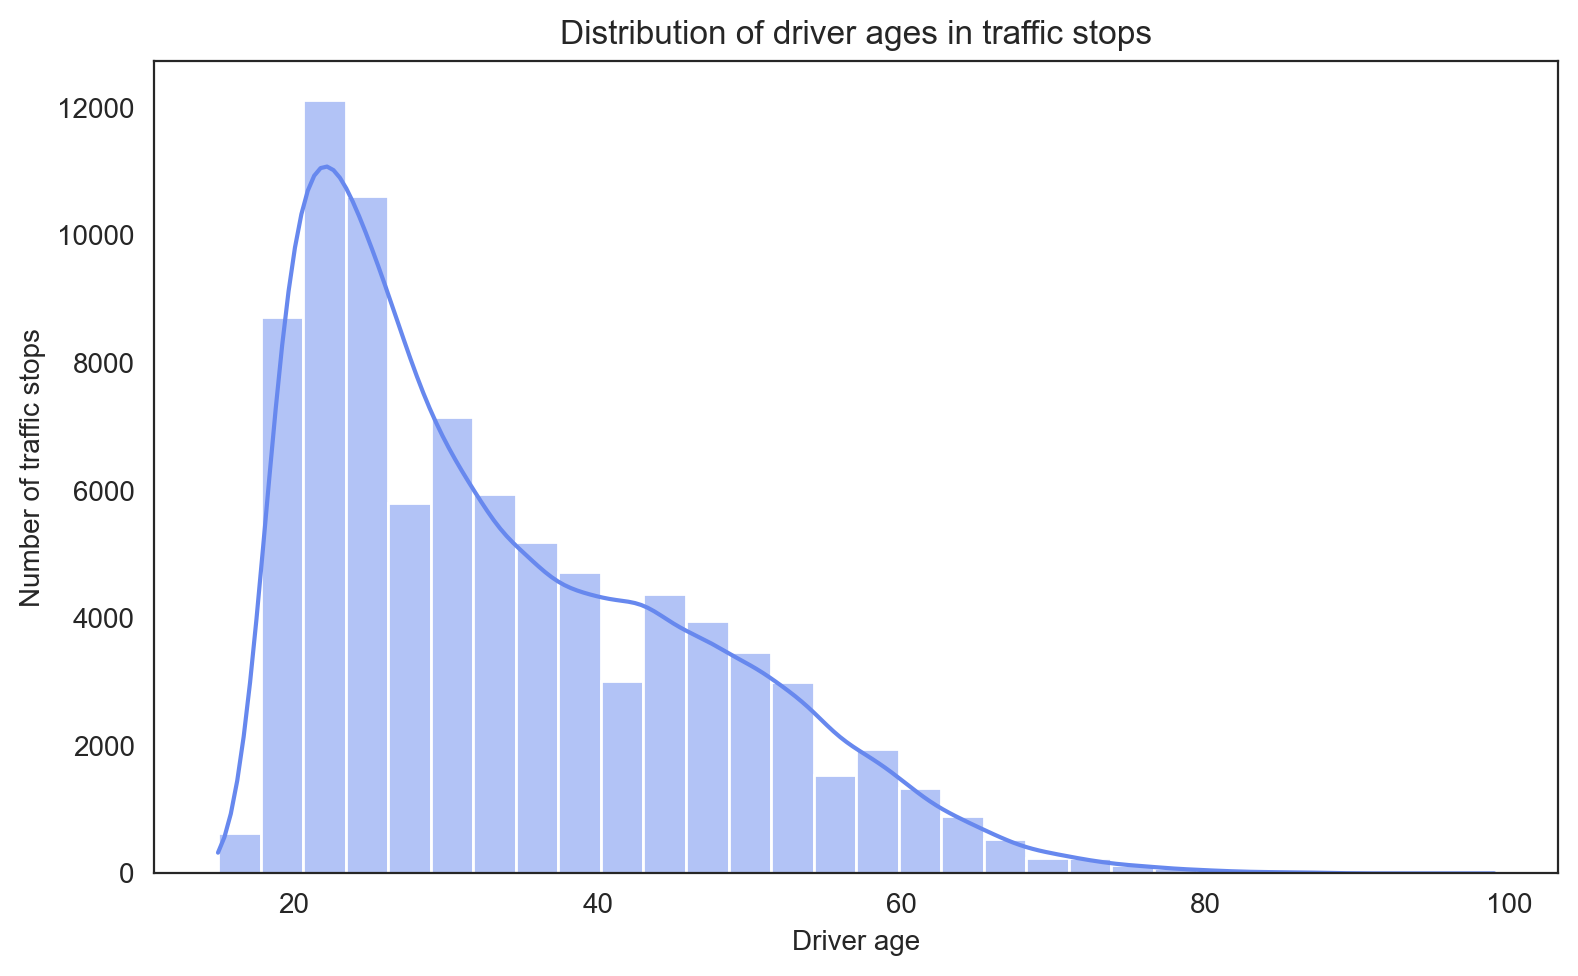

In [127]:
df = load_data()

plt.figure(figsize=(8, 5))
sns.histplot(
    df["driver_age"],
    bins=30,
    kde=True
)

plt.xlabel("Driver age")
plt.ylabel("Number of traffic stops")
plt.title("Distribution of driver ages in traffic stops")
plt.tight_layout()
plt.show()


the most traffic stops happen around age 20 and no or very little at the age 80 and higher

## Task 8 - Analyze whether stop duration influences the probability of an arrest.

<div class="alert alert-block alert-success">

- Analyze how the duration of traffic stops influences the likelihood of an arrest.

- The analysis can be tabular or visual.

- Provide a brief description.
    
</div>

In case of Tabular-Results, it should be similar to this:

| stop_duration   |   is_arrested |
|:----------------|--------------:|
| 0-15 Min        |     0.0123334 |
| 16-30 Min       |     0.0911045 |
| 30+ Min         |     0.253367  |

In [ ]:
df = load_data()

# WRITE YOUR CODE HERE

Add your brief description

## Task 9 -  Study how stop duration has changed over time to identify evolving policing practices.

<div class="alert alert-block alert-success">

- Visualize how stop duration changes over time.
- Provide a brief description.

</div>


In [ ]:
df = load_data()

# WRITE YOUR CODE HERE

Add your brief description

## Task 10 - Use a large language model to suggest additional insightful analyses of the dataset.

<div class="alert alert-block alert-success">

- Request additional analysis suggestions from a large language model (LLM).
- Select one suggested analysis and perform it.
- Provide a brief description.
    
</div>

In [ ]:
# Use ChatGPT...

Add your brief description

<hr> 

# Submit two-fold via Moodle:
- Your notebook 
- A html export of this notebook

### You must hand in this exercise via moodle